# Taxi Dataset

Download the CSV Files from: 
* 2018 yellow cab taxi rides (112M lines; may sample down to 1M for convenience): https://data.cityofnewyork.us/Traasportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq
* taxi zone names and polygons: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

Store them in this directory ("datasets") as `taxis.csv` and `taxi_zones.csv`, respectively.

### Transform/Filter the data for use with the sampling pipeline

#### Precompute polygons

In [1]:
import pandas as pd
import numpy as np
import random
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Point

rides_df = pd.read_csv("./taxis.csv", delimiter=";", parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
zones_df = pd.read_csv("./taxi_zones.csv")


zones_df = zones_df[["LocationID", "the_geom"]].set_index("LocationID")
rides_df = rides_df.join(zones_df, on="PULocationID")
rides_df = rides_df.join(zones_df, on="DOLocationID", rsuffix="DO")


# make temporal dimensions numeric (some parts of the pipeline break when data is string or object)
rides_df["tpep_pickup_datetime"] = rides_df["tpep_pickup_datetime"].astype(np.int64)
rides_df["tpep_dropoff_datetime"] = rides_df["tpep_dropoff_datetime"].astype(np.int64)

# only keep rows with a dropoff and a pickup point (i.e., no NaN entries)
rides_df = rides_df[rides_df["the_geom"].notnull() & rides_df["the_geomDO"].notnull()]


def generate_representative(poly: MultiPolygon):
  '''Computes a random location inside the polygon until that location actually lies inside the 
     polygon. This random location is used as a representative point for the polygon in the 
     dataset.'''
  min_x, min_y, max_x, max_y = poly.bounds
  pos = [-1, -1]
  is_inside = False
  while not is_inside:
    pos[0] = random.uniform(min_x, max_x)
    pos[1] = random.uniform(min_y, max_y)
    is_inside = poly.contains(Point(pos))
  return np.array(pos).reshape(2, 1)

# generate a representative geo point for each taxi ride's pick-up and drop-off location, so that 
# we can linearize by geospace
PUrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geom"])), 
  axis=1
)

# np.stack turns array of objects into array of arrays
PUrepresentatives = np.stack(PUrepresentatives)

DOrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geomDO"])), 
  axis=1
)
DOrepresentatives = np.stack(DOrepresentatives)

# store lat and lng as separate attributes
rides_df["PUrepresentativeX"] = PUrepresentatives[:, 0]
rides_df["PUrepresentativeY"] = PUrepresentatives[:, 1]
rides_df["DOrepresentativeX"] = DOrepresentatives[:, 0]
rides_df["DOrepresentativeY"] = DOrepresentatives[:, 1]

# drop unneeded geometry and non-numerical cols
rides_df.drop(columns=["the_geom", "the_geomDO", "store_and_fwd_flag"], inplace=True)

# write the update data back to the file
rides_df.to_csv("./taxisData.csv", sep=";", index=False, header=False)
# takes about 15:30 minutes for 1M 

,tripID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PUrepresentativeX,PUrepresentativeY,DOrepresentativeX,DOrepresentativeY
0,31852922,2,1531894631000000000,1531894986000000000,2,2.00,1,249,161,1,...,0.0,0.5,1.66,0.0,0.3,9.96,-74.003550,40.735432,-73.979061,40.760191
2,66379394,2,1543079254000000000,1543079627000000000,2,1.03,1,239,238,2,...,0.0,0.5,0.00,0.0,0.3,6.80,-73.982997,40.784969,-73.975581,40.796648
3,10428271,2,1529052094000000000,1529052461000000000,1,0.82,1,249,114,1,...,0.0,0.5,1.70,0.0,0.3,8.50,-74.003843,40.738248,-74.001054,40.729904
4,23940933,1,1517557388000000000,1517557818000000000,2,1.80,1,239,166,1,...,0.0,0.5,0.42,0.0,0.3,8.72,-73.973974,40.782954,-73.961370,40.802496
5,49711511,2,1537870383000000000,1537870752000000000,1,1.18,1,236,75,1,...,0.0,0.5,2.04,0.0,0.3,8.84,-73.962603,40.778264,-73.946020,40.786771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,48567407,2,1537483040000000000,1537483591000000000,4,1.90,1,141,142,1,...,0.5,0.5,1.96,0.0,0.3,11.76,-73.964590,40.762222,-73.984669,40.771851
999996,67297900,2,1543403399000000000,1543404288000000000,6,1.78,1,246,164,2,...,0.0,0.5,0.00,0.0,0.3,11.80,-74.000827,40.761110,-73.983446,40.750464
999997,19204703,1,1516189304000000000,1516189680000000000,1,0.70,1,162,237,1,...,0.0,0.5,2.00,0.0,0.3,8.80,-73.976325,40.752441,-73.964218,40.775249
999998,53762823,4,1539157874000000000,1539158194000000000,1,0.84,1,249,125,1,...,0.0,0.5,1.26,0.0,0.3,7.56,-73.998243,40.736155,-74.014296,40.726423


#### Precompute spatial autocorrelation (run the previous cell first!)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree

# reproduces the autocorrelation computation outlined here: 
# https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

# find the knn for each point
columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]

rides_df = pd.read_csv("./taxisData.csv", delimiter=";", names=columns)


X = rides_df.to_numpy()

# constants for indeces of important columns in the np array 
LAT = 17
LON = 18
TRIP_DISTANCE = 5
TRIP_ID = 0

tree = KDTree(X[:, [LAT, LON]])
dist, knn = tree.query(X[:, [LAT, LON]], k=9)  # using k=8 (+1, as first match is item itself)

# first match to query is the item itself, so remove that one
dist = dist[:, 1:]
knn = knn[:, 1:]

# compute the weights for the knn per point (the closer, the greater the weight)
w = 1 / dist 
w = w / w.sum(axis=1).reshape(-1, 1)

# compute the weighted knn value per point (i.e., the spatial lag)
knn_value = X[knn][:, :, TRIP_DISTANCE]  # get the value column per neighbor
spatial_lag = knn_value * w  # multiply the value vector with weights
spatial_lag = spatial_lag.sum(axis=1)

# compute the normalized actual value
mean_value = np.mean(X[:, TRIP_DISTANCE], axis=0)
normalized_value = X[:, TRIP_DISTANCE] - mean_value

# compute the normalized lag value
mean_spatial_lag = np.mean(spatial_lag, axis=0)
normalized_spatial_lag = spatial_lag - mean_spatial_lag

# compute the H/L labels, indicating the quadrants in the Moran's plot
value_is_H = normalized_value > 0
spatial_lag_is_H = normalized_spatial_lag > 0
# value_is_H.astype(int) + spatial_lag_is_H.astype(int)

spatial_auto_df = pd.DataFrame(
  np.array([
    X[:, TRIP_ID], 
    normalized_value,
    normalized_spatial_lag,
    value_is_H,
    spatial_lag_is_H,
  ]).T,
  columns=[
    "tripID",
    "normalized_value",
    "normalized_spatial_lag",
    "value_is_H",
    "spatial_lag_is_H"
  ],
).set_index("tripID")
rides_df.astype({"tripID": int}).set_index("tripID").join(spatial_auto_df).to_csv("taxisData.csv", sep=";", index=True, header=False)

Moran Plot:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.regplot(
  x=normalized_value,
  y=normalized_spatial_lag,
  # ci=None,
  color="r",
  scatter_kws={"s": 0.1, "alpha": 0.3}
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title('Moran Plot - trip_distance')
plt.show()

#### Precompute LocalOutlierFactor Scores

In [15]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor


header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

clf = LocalOutlierFactor(n_neighbors=10)

df = pd.read_csv("./taxisData.csv", sep=";", names=header)
outlierness = pd.DataFrame(clf.negative_outlier_factor_, index=df["tripID"])
outlierness.to_csv("outlierness.csv", sep=";")

0         31852922
1         66379394
2         10428271
3         23940933
4         49711511
            ...   
982877    48567407
982878    67297900
982879    19204703
982880    53762823
982881    56788328
Name: tripID, Length: 982882, dtype: int64

For simplicity, we consider items as "outlier" that lies outside the 4th quantile:

In [1]:
import pandas as pd

df = pd.read_csv("outlierness.csv", sep=";")["0"]
df.describe()

count    982882.000000
mean         -1.020146
std           0.085341
min         -28.961741
25%          -1.037116
50%          -1.010160
75%          -0.990033
max          -0.890753
Name: 0, dtype: float64

outlier
inlier


<AxesSubplot:xlabel='PURepresentativeX', ylabel='PURepresentativeY'>

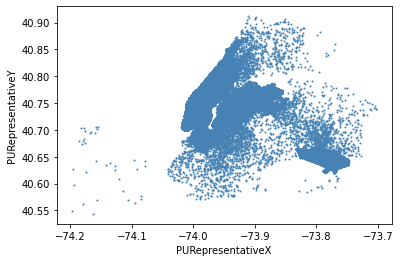

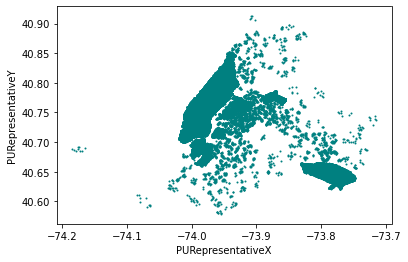

In [8]:
import pandas as pd

outlierness = pd.read_csv("./outlierness.csv", sep=";")
outlierness.columns = ["tripID", "score"]
outlierness.set_index("tripID", inplace=True)

columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]

df = pd.read_csv("./taxisData.csv", sep=";", names=columns)
df.set_index("tripID", inplace=True)
df = df.join(outlierness)

print("outlier")
df[df["score"] < -1].plot.scatter(x="PURepresentativeX", y="PURepresentativeY", s=1, c="steelblue")
print("inlier")
df[df["score"] > -1].plot.scatter(x="PURepresentativeX", y="PURepresentativeY", s=1, c="teal")

### Dataset summary

In [51]:
import pandas as pd

columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

rides_df = pd.read_csv("./taxisData.csv", sep=";", names=columns)
pd.set_option('display.max_columns', 500)
rides_df.describe().loc[["min", "max"]]

,tripID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PURepresentativeX,PURepresentativeY,DORepresentativeX,DORepresentativeY,normalized_value,normalized_spatial_lag,value_is_H,spatial_lag_is_H
min,73.0,1.0,1.041384e+18,1.041384e+18,0.0,0.01,1.0,1.0,1.0,1.0,0.01,-0.49,0.0,0.0,0.0,0.0,0.31,-74.197663,40.543353,-74.254741,40.504555,-2.928987,-2.738654,0.0,0.0
max,76955200.0,4.0,1.607632e+18,1.607634e+18,9.0,63.30,99.0,263.0,263.0,4.0,398.00,17.50,0.5,300.0,950.7,0.3,1003.50,-73.702319,40.912294,-73.701511,40.914637,60.361013,26.416724,1.0,1.0


### Plot distribution of pickup location

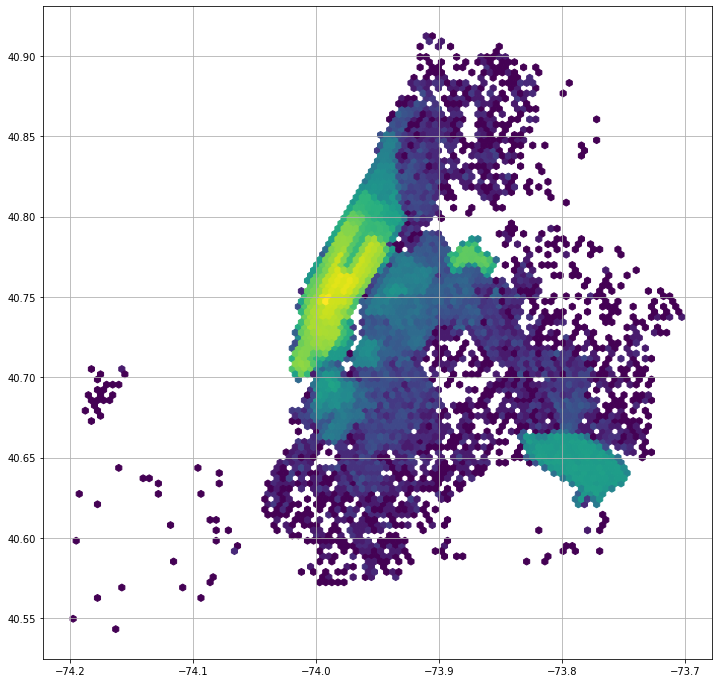

In [8]:
# plot the rides dataset in hexbinned histogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

df = pd.read_csv("./taxisData.csv", delimiter=";", names=header)

image = plt.hexbin(
  x=df["PURepresentativeX"], 
  y=df["PURepresentativeY"],
  bins="log",
  mincnt=1,
  gridsize=100,
)

plt.grid(True, )
# to get the computed bins, use 
# image.get_array()

### Plot the time distribution

'done'

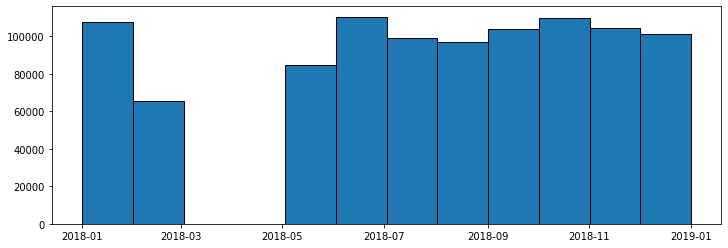

In [1]:
# plot the rides dataset in hexbinned histogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

df = pd.read_csv("./taxisData.csv", delimiter=";", names=header)

plt.hist(
  pd.to_datetime(df["tpep_pickup_datetime"]), 
  bins=12,
  range=('2018-01-01 00:00:00', '2018-12-31 23:59:59'),
  edgecolor="black",
  linewidth=1
)
"done"

### Plot the trip distance distribution

'done'

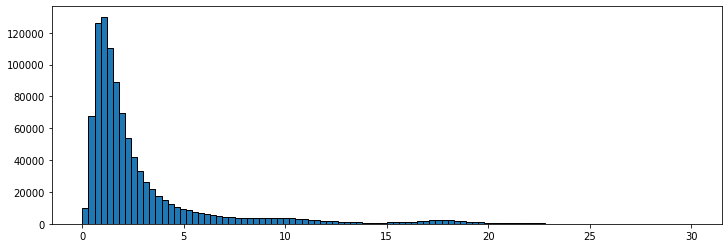

In [2]:
# plot the rides dataset in hexbinned histogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

df = pd.read_csv("./taxisData.csv", delimiter=";", names=header)

plt.hist(
  df["trip_distance"], 
  bins=100,
  range=(0, 30),
  edgecolor="black",
  linewidth=1
)
"done"

### Precompute linearizations

In [1]:
import pandas as pd
import sys
import os

sys.path.append(f"{os.getcwd()}/../../../")  # HACK to make relative imports work in notebooks

from pipeline.linearizations.Linearization import LinearizationDatetimeAttr, LinearizationNumericAttr, LinearizationGeoZorder, LinearizationRandom

LinearizationRandom("taxis", 25).linearize()  # random shuffling
LinearizationDatetimeAttr("taxis", 25, 2).linearize()  # sort by pickup date
LinearizationNumericAttr("taxis", 25, 5).linearize()  # sort by trip distance
LinearizationGeoZorder("taxis", 25, 17, 18).linearize()  # sort by pickup location

"done"

Saved linearized data in c:\Users\au629923\Repositories\prosample\server\pipeline\linearizations\datasets\..\..\..\pipeline\linearizations/../linearization_files/taxisLinearizationRandom.csv
Saved linearized data in c:\Users\au629923\Repositories\prosample\server\pipeline\linearizations\datasets\..\..\..\pipeline\linearizations/../linearization_files/taxisLinearizationSortByTempAttr.csv
Saved linearized data in c:\Users\au629923\Repositories\prosample\server\pipeline\linearizations\datasets\..\..\..\pipeline\linearizations/../linearization_files/taxisLinearizationSortByNumAttr.csv
Saved linearized data in c:\Users\au629923\Repositories\prosample\server\pipeline\linearizations\datasets\..\..\..\pipeline\linearizations/../linearization_files/taxisLinearizationZOrder.csv


'done'

### Plot a linearization:

<AxesSubplot:xlabel='PURepresentativeX'>

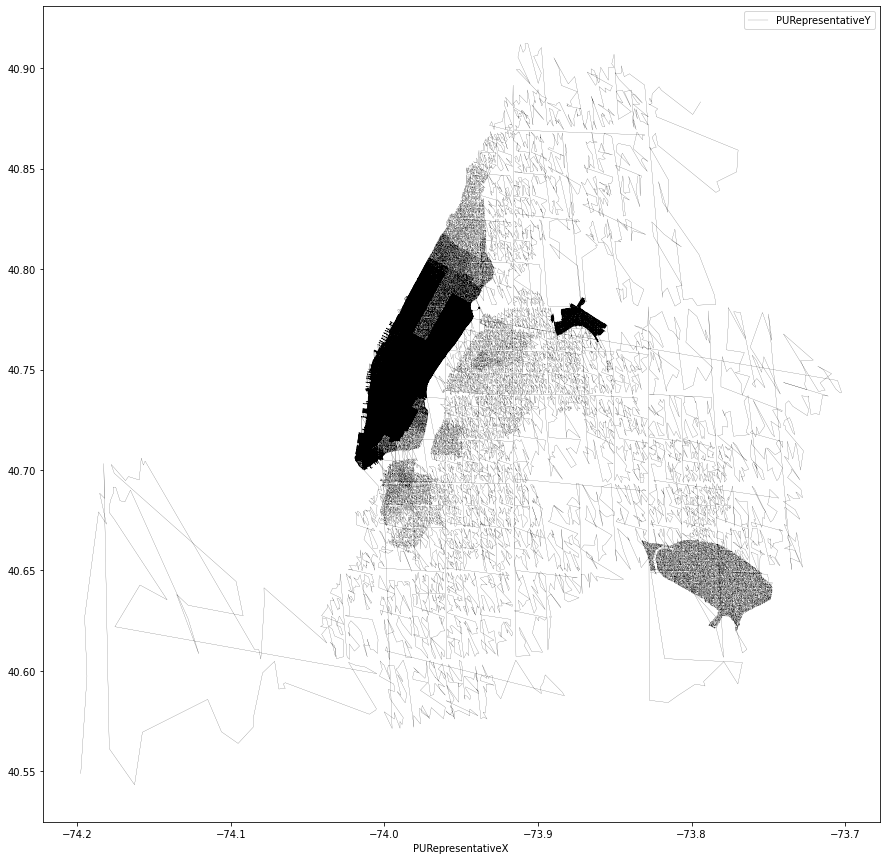

In [4]:
import pandas as pd

header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY", "normalized_value", "normalized_spatial_lag", "value_is_H", "spatial_lag_is_H"]

df = pd.read_csv("../../linearization_files/taxisLinearizationZOrder.csv", delimiter=";", names=header)

df.plot.line(x="PURepresentativeX", y="PURepresentativeY", figsize=[15, 15], c="black", lw=0.15)